In [1]:
import sys
import random
import time
from datetime import datetime

from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import glob
import geopandas as gpd

C:\Users\DELL\anaconda3\envs\geos\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
PROJ: proj_create_from_database: Cannot find proj.db


## Part I: Data Extraction

In [2]:
url = r'https://matokeo.necta.go.tz/csee2022/index.htm'
pg = requests.get(url)
soup = bs(pg.content, 'html.parser')

### Links Extraction

In [3]:
table = soup.find_all('table')[2]
links = table.find_all('a')

# links
s_links = []
for link in links:
    lintext = link.text.strip()
    if not lintext.startswith('P'): # Remove links to private candidate results, school candidate results start with S
        s_links.append(link)
# print(s_links[110]) # For confirming links while setting milestones


In [5]:

n_retry = 0
def get_region(lin):
    page = requests.get(lin)
    sp = bs(page.content, 'html.parser')
    reg = sp.find_all('table')[4].find_all('p')[1].text
    return reg
        
    

def fetch_results(lin, name):
    
    
    global n_retry
    try:
        # Warning: Improvisation ahead
        # Bad HTML Tables
        # Will read 'CIVICS' info as headers
        ts = pd.read_html(lin, header = 0)
    #         print(len(ts))
        df = ts[1]
        school_gpa = float(ts[2].iloc[0,1].split(' ')[0])

        df['centre_ref'] = name.split(' ')[0].strip()
        df['centre_name'] = ' '.join(name.split(' ')[1:])
        df['region'] = get_region(lin)
        n_retry = 0
        school_sat = float(ts[-3].columns[2])
        school_regd = float(ts[-3].columns[0])
        subjs_df = ts[-1]
        math_df = subjs_df[subjs_df.CIVICS == 'BASIC MATHEMATICS']
        math_gpa = float(math_df.iloc[0,-2])
        math_sat = float(math_df.iloc[0,3])
        
        swahili_df = subjs_df[subjs_df.CIVICS == 'KISWAHILI']
        swahili_gpa = float(swahili_df.iloc[0,-2])
        swahili_sat = float(swahili_df.iloc[0,3])
        
        school_data = {
            'name': name,
            'school_gpa': school_gpa,
            'math_gpa': math_gpa,
            'school_regd': school_regd,
            'school_sat': school_sat,
            'math_sat': math_sat,
            'swahili_gpa': swahili_gpa,
            'swahili_sat': swahili_sat,
        }
#         print(school_data)
        return ts[1], school_data
    
    except:
        n_retry += 1
        time.sleep(3)
        if n_retry <=5:
            print(f'Retrying .... #{n_retry}')
            fetch_results(lin,name)
            
        return None, {}
    
    

###==================START HERE ===============================
res_tables = []
schools_data = []
#Milestones are recovery points in case of network failure or blocking
# step, next_stop and milestones can be changed according to the point of recovery
milestone = 0
count = milestone

# A point in the list of links where the loop will stop, 
# they are used to divide the task into different notebooks and machines
next_stop = 100 
step = 10
n_links = len(links[milestone:next_stop]) 

for j in range(milestone, next_stop ,step):
    print(datetime.now())
    print('*---*   ' * 10 )
    print(f'Working from {j+1} to {j+step}')
    print('-'*50)
    for link in s_links[j:j+step]:
        t = random.randint(0,2)
#         time.sleep(t)
        lintext = link.text.strip()

        href = r'https://matokeo.necta.go.tz/csee2022/' + link.get('href').replace('\\','/')

    #     if lintext.startswith('S'):
        print('{0}. Fetching {1}'.format(count+1, lintext))
        print('\t' + href)
        results, school_data = fetch_results(href, lintext)
        if school_data == {}:
            count+=1
            continue
        res_tables.append(results)
        schools_data.append(school_data)

        count +=1
    my_df = pd.concat(res_tables)
    
    # Demo Path
    my_df.to_csv(r'2022\csee{}_{}.csv'.format(j+1,j+step))
    
    # Actual Path
    #     my_df.to_csv(r'G:\My Drive\consultancy\CSEE2022 Analysis\2022\csee{}_{}.csv'.format(j+1,j+step)) 
    res_tables = []
    
    
    schools_df = pd.DataFrame(schools_data)
     # Demo Path
    my_df.to_csv(r'2022\csee{}_{}.csv'.format(j+1,j+step))
    
    # Actual Path
#     schools_df.to_csv(r'G:\My Drive\consultancy\CSEE2022 Analysis\2022\schools{}_{}.csv'.format(j+1,j+step))
    schools_data = []
    

2023-02-13 12:33:45.851114
*---*   *---*   *---*   *---*   *---*   *---*   *---*   *---*   *---*   *---*   
Working from 1 to 10
--------------------------------------------------
1. Fetching S0101 AZANIA
	https://matokeo.necta.go.tz/csee2022/results/s0101.htm
2. Fetching S0104 BWIRU BOYS
	https://matokeo.necta.go.tz/csee2022/results/s0104.htm
3. Fetching S0106 DUNG'UNYI SEMINARY
	https://matokeo.necta.go.tz/csee2022/results/s0106.htm
4. Fetching S0107 LUTHERAN JUNIOR SEMINARY
	https://matokeo.necta.go.tz/csee2022/results/s0107.htm
5. Fetching S0108 IFUNDA TECHNICAL
	https://matokeo.necta.go.tz/csee2022/results/s0108.htm
6. Fetching S0110 ILBORU
	https://matokeo.necta.go.tz/csee2022/results/s0110.htm
7. Fetching S0111 ITAGA SEMINARY
	https://matokeo.necta.go.tz/csee2022/results/s0111.htm
8. Fetching S0112 IYUNGA TECHNICAL
	https://matokeo.necta.go.tz/csee2022/results/s0112.htm
9. Fetching S0113 MAFINGA SEMINARY
	https://matokeo.necta.go.tz/csee2022/results/s0113.htm
10. Fetching S0114 

74. Fetching S0209 KOROGWE GIRLS
	https://matokeo.necta.go.tz/csee2022/results/s0209.htm
75. Fetching S0210 BIGWA SISTERS SEMINARY
	https://matokeo.necta.go.tz/csee2022/results/s0210.htm
76. Fetching S0214 MSALATO
	https://matokeo.necta.go.tz/csee2022/results/s0214.htm
77. Fetching S0217 PERAMIHO GIRLS
	https://matokeo.necta.go.tz/csee2022/results/s0217.htm
78. Fetching S0218 RUGAMBWA
	https://matokeo.necta.go.tz/csee2022/results/s0218.htm
79. Fetching S0220 TABORA GIRLS
	https://matokeo.necta.go.tz/csee2022/results/s0220.htm
80. Fetching S0222 ZANAKI
	https://matokeo.necta.go.tz/csee2022/results/s0222.htm
2023-02-13 12:35:34.207356
*---*   *---*   *---*   *---*   *---*   *---*   *---*   *---*   *---*   *---*   
Working from 81 to 90
--------------------------------------------------
81. Fetching S0223 MASAMA GIRLS
	https://matokeo.necta.go.tz/csee2022/results/s0223.htm
82. Fetching S0224 KIFUNGILO GIRLS
	https://matokeo.necta.go.tz/csee2022/results/s0224.htm
83. Fetching S0225 CAGLIER

## Part II: Regional Analysis

In [107]:
path = r'G:\My Drive\consultancy\CSEE2022 Analysis\2022' 
all_files = glob.glob(path + "/*.csv")
# print(all_files)
li = []
print('Loading ', end=' -> ')
for filename in all_files:
    fname = filename.split('\\')[-1]
#     print(fname)
    if fname.startswith('csee'):
        print('|', end='')
        df = pd.read_csv(filename, index_col=None, header=0, usecols = ['CNO','SEX','AGGT','DIV','DETAILED SUBJECTS',
                                                                        'centre_ref','centre_name','region'])

        li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame = frame.drop_duplicates()
frame

Loading  -> ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

,CNO,SEX,AGGT,DIV,DETAILED SUBJECTS,centre_ref,centre_name,region
0,S0101/0001,M,17,I,CIV - 'C' HIST - 'C' GEO - 'C' KISW - 'C' ENGL...,S0101,AZANIA,DAR ES SALAAM
1,S0101/0002,M,27,IV,CIV - 'F' HIST - 'D' GEO - 'F' KISW - 'C' ENGL...,S0101,AZANIA,DAR ES SALAAM
2,S0101/0003,M,11,I,CIV - 'B' HIST - 'B' GEO - 'B' KISW - 'B' ENGL...,S0101,AZANIA,DAR ES SALAAM
3,S0101/0004,M,22,III,CIV - 'C' HIST - 'D' GEO - 'C' KISW - 'C' ENGL...,S0101,AZANIA,DAR ES SALAAM
4,S0101/0005,M,11,I,CIV - 'C' HIST - 'B' GEO - 'B' KISW - 'C' ENGL...,S0101,AZANIA,DAR ES SALAAM
...,...,...,...,...,...,...,...,...
534629,S6310/0035,M,22,III,CIV - 'C' GEO - 'C' E/D/KIISLAMU - 'F' KISW - ...,S6310,MGELEMA,KUSINI PEMBA
534630,S6310/0036,M,34,0,CIV - 'F' GEO - 'F' E/D/KIISLAMU - 'F' KISW - ...,S6310,MGELEMA,KUSINI PEMBA
534631,S6310/0037,M,28,IV,CIV - 'D' GEO - 'D' E/D/KIISLAMU - 'F' KISW - ...,S6310,MGELEMA,KUSINI PEMBA
534632,S6310/0038,M,27,IV,CIV - 'D' GEO - 'D' E/D/KIISLAMU - 'F' KISW - ...,S6310,MGELEMA,KUSINI PEMBA


In [108]:
tz_adm = gpd.read_file(r'tza_admbnda_adm1_20181019\tza_admbnda_adm1_20181019.shp')
tz_adm = tz_adm[['ADM1_EN',  'geometry']]
tz_adm.head(5)

,ADM1_EN,geometry
0,Arusha,"POLYGON ((35.32059 -1.71952, 35.39328 -1.76093..."
1,Dar-es-salaam,"MULTIPOLYGON (((39.27007 -6.69830, 39.26734 -6..."
2,Dodoma,"MULTIPOLYGON (((35.65407 -4.52047, 35.65403 -4..."
3,Geita,"MULTIPOLYGON (((31.81659 -2.69949, 31.81540 -2..."
4,Iringa,"POLYGON ((34.93466 -6.88891, 34.93743 -6.88938..."


In [109]:
reg_results = frame[['CNO', 'AGGT', 'DIV', 'region']]
reg_results.loc[:, 'region'] = reg_results.region.str.title()
reg_results.replace({'region':{'Dar Es Salaam': 'Dar-es-salaam'}}, inplace = True)

reg_results

C:\Users\DELL\AppData\Local\Temp\ipykernel_15164\2017778028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_results.loc[:, 'region'] = reg_results.region.str.title()
C:\Users\DELL\AppData\Local\Temp\ipykernel_15164\2017778028.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_results.replace({'region':{'Dar Es Salaam': 'Dar-es-salaam'}}, inplace = True)


,CNO,AGGT,DIV,region
0,S0101/0001,17,I,Dar-es-salaam
1,S0101/0002,27,IV,Dar-es-salaam
2,S0101/0003,11,I,Dar-es-salaam
3,S0101/0004,22,III,Dar-es-salaam
4,S0101/0005,11,I,Dar-es-salaam
...,...,...,...,...
534629,S6310/0035,22,III,Kusini Pemba
534630,S6310/0036,34,0,Kusini Pemba
534631,S6310/0037,28,IV,Kusini Pemba
534632,S6310/0038,27,IV,Kusini Pemba


In [110]:

I_s = reg_results[reg_results.DIV == 'I']
div_I = I_s.groupby(['region','DIV']).count()
div_I.rename(columns = {'CNO':'Div_I'}, inplace = True)
div_I.sort_values(by = 'Div_I', inplace = True)

II_s = reg_results[reg_results.DIV == 'II']
div_II = II_s.groupby(['region','DIV']).count()
div_II.rename(columns = {'CNO':'Div_II'}, inplace = True)
div_II.sort_values(by = 'Div_II', inplace = True)

III_s = reg_results[reg_results.DIV == 'III']
div_III = III_s.groupby(['region','DIV']).count()
div_III.rename(columns = {'CNO':'Div_III'}, inplace = True)
div_III.sort_values(by = 'Div_III', inplace = True)

IV_s = reg_results[reg_results.DIV == 'IV']
div_IV = IV_s.groupby(['region','DIV']).count()
div_IV.rename(columns = {'CNO':'Div_IV'}, inplace = True)
div_IV.sort_values(by = 'Div_IV', inplace = True)


O_s = reg_results[reg_results.DIV == '0']
div_0 = O_s.groupby(['region','DIV']).count()
div_0.rename(columns = {'CNO':'Div_0'}, inplace = True)
div_0.sort_values(by = 'Div_0', inplace = True)

ABS_s = reg_results[reg_results.DIV == 'ABS']
ABS = ABS_s.groupby(['region','DIV']).count()
ABS.rename(columns = {'CNO':'ABS'}, inplace = True)
ABS.sort_values(by = 'ABS', inplace = True)

# ABS

In [111]:
adm_results = tz_adm.merge(reg_results, left_on = 'ADM1_EN', right_on = 'region')
adm_results.head(5)

,ADM1_EN,geometry,CNO,AGGT,DIV,region
0,Arusha,"POLYGON ((35.32059 -1.71952, 35.39328 -1.76093...",S0110/0001,14,I,Arusha
1,Arusha,"POLYGON ((35.32059 -1.71952, 35.39328 -1.76093...",S0110/0002,9,I,Arusha
2,Arusha,"POLYGON ((35.32059 -1.71952, 35.39328 -1.76093...",S0110/0003,15,I,Arusha
3,Arusha,"POLYGON ((35.32059 -1.71952, 35.39328 -1.76093...",S0110/0004,8,I,Arusha
4,Arusha,"POLYGON ((35.32059 -1.71952, 35.39328 -1.76093...",S0110/0005,7,I,Arusha


In [112]:
x = reg_results.groupby(['region','DIV']).count()[['CNO']]
div_result = x.unstack(level = -1)
div_result = div_result.fillna(0).astype(int)
div_result = div_result.droplevel(0, axis = 1)
div_result = div_result.drop(columns = ['*E','*R',  '*W', '-', 'ABS'])
div_result['total'] = div_result.sum(axis = 1)
div_result['I_pct'] = div_result.I/div_result.total*100
div_result['good_pct'] = (div_result.I+div_result.II+div_result.III)/div_result.total*100
div_result['low_pct'] = (div_result.IV+div_result['0'])/div_result.total*100
div_result = div_result.sort_values(by = 'low_pct', ascending = False)

div_result.head(5)

DIV,*S,*T,0,I,II,III,IV,total,I_pct,good_pct,low_pct
region,,,,,,,,,,,
Kaskazini Unguja,18,2,900,6,83,301,1573,2883,0.208117,13.527575,85.778703
Kaskazini Pemba,19,0,1412,28,192,470,2123,4244,0.659755,16.258247,83.294062
Kusini Unguja,4,0,315,32,113,279,1333,2076,1.541426,20.423892,79.383430
Kusini Pemba,13,1,1473,138,260,485,1893,4263,3.237157,20.713113,78.958480
Tanga,14,2,3793,1481,2165,3132,13469,24056,6.156468,28.175923,71.757566


In [113]:
tz_results = tz_adm.merge(div_result, left_on = 'ADM1_EN', right_on = 'region', how = 'inner')
tz_results['centre'] = tz_results.geometry.centroid
zenj = ['Mjini Magharibi',  'Kusini Pemba', 'Kaskazini Pemba',
        'Kaskazini Unguja', 'Kusini Unguja', ]
zenj_results = tz_results[tz_results['ADM1_EN'].isin(zenj)]
tz_results =  tz_results[ ~(tz_results['ADM1_EN'].isin(zenj))].sort_values(by = 'low_pct', ascending = False)


C:\Users\DELL\AppData\Local\Temp\ipykernel_15164\3826538147.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tz_results['centre'] = tz_results.geometry.centroid


C:\Users\DELL\anaconda3\envs\geos\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


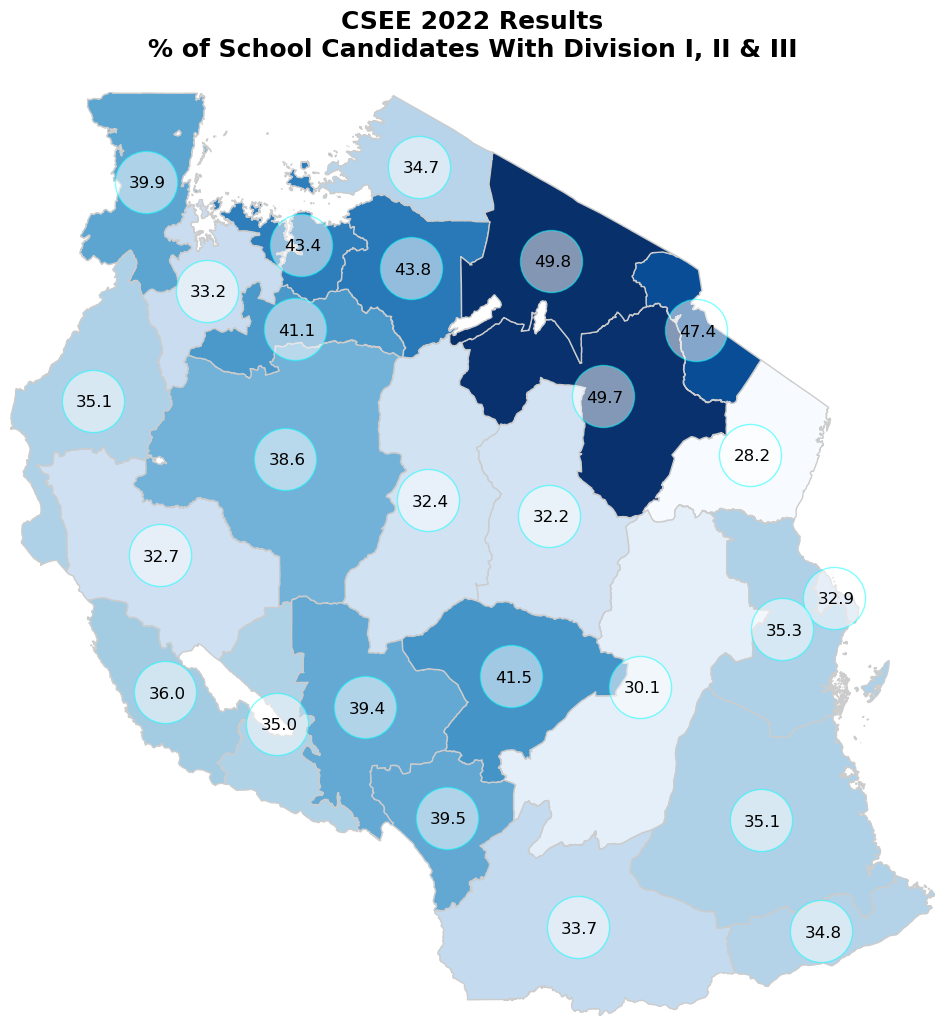

In [114]:
base = tz_results.plot(figsize = (12,12), column = 'good_pct', legend = False, cmap = 'Blues',
                k =5, edgecolor = '#ccc', linewidth = 1,
                 legend_kwds={'label': "% with Division I,II & III",'orientation': "vertical"}) #scheme = 'quantiles',
tz_results.centre.plot(ax = base, color = 'white', markersize = 2000, alpha = 0.5, edgecolor = 'cyan', lw = 1)
base.set_axis_off()
for x,y,value  in zip(tz_results.centre.x, tz_results.centre.y, tz_results.good_pct):
    base.annotate(round(value,1), xy=(x,y), xytext = (-12,-4), textcoords = 'offset points', fontsize = 12)
plt.title('CSEE 2022 Results\n% of School Candidates With Division I, II & III\n',fontdict = {'fontsize': 18,
        'fontweight': 'bold',
        'color': 'black',}
        )
base.margins(0)
# plt.savefig('good_pct-2021.png', dpi = 300)

C:\Users\DELL\anaconda3\envs\geos\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


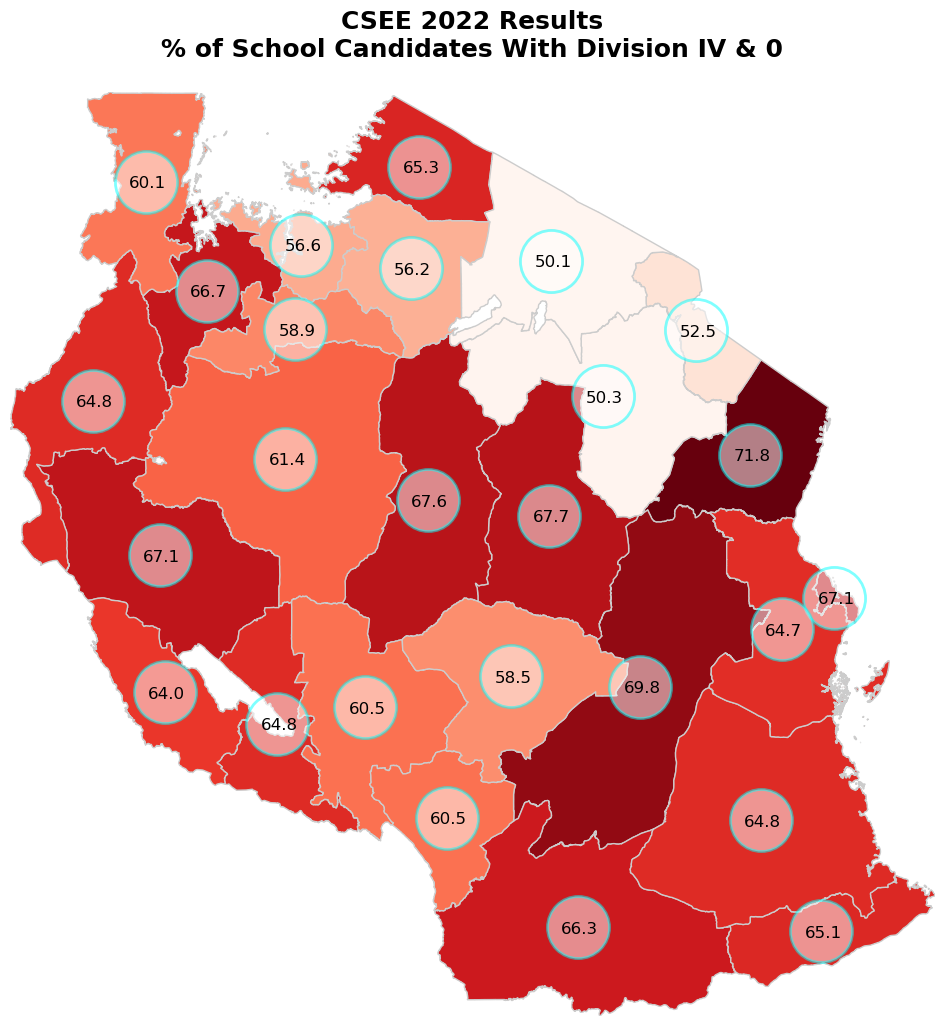

In [115]:
base = tz_results.plot(figsize = (12,12), column = 'low_pct', legend = False, cmap = 'Reds',
                k =5, edgecolor = '#ccc', linewidth = 1,
                       legend_kwds={'label': "% with Division I,II & III",'orientation': "horizontal"}) #scheme = 'quantiles',
tz_results.centre.plot(ax = base, color = 'white', markersize = 2000, alpha = 0.5, edgecolor = 'cyan', lw = 2)

for x,y,value  in zip(tz_results.centre.x, tz_results.centre.y, tz_results.low_pct):
    base.annotate(round(value,1), xy=(x,y), xytext = (-12,-4), textcoords = 'offset points', fontsize = 12)
base.set_axis_off()
plt.title('CSEE 2022 Results\n% of School Candidates With Division IV & 0\n',fontdict = {'fontsize': 18,
        'fontweight': 'bold',
        'color': 'black',}
        )
base.margins(0)
# plt.savefig('low_pct-2021.png', dpi = 300)

C:\Users\DELL\anaconda3\envs\geos\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\Users\DELL\anaconda3\envs\geos\lib\site-packages\geopandas\plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


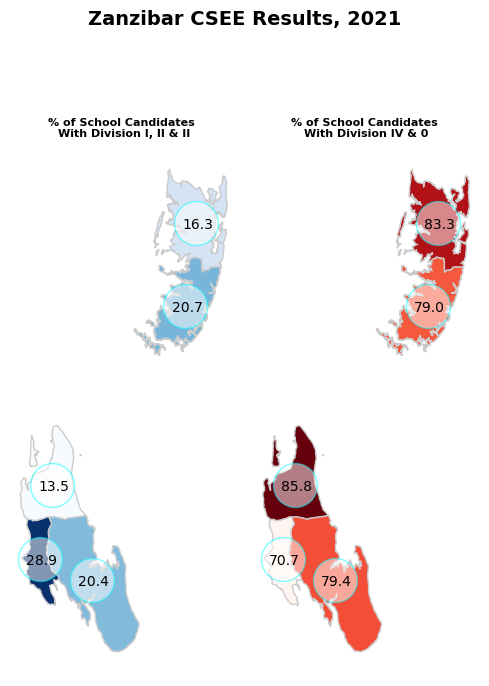

In [139]:

fig, ax = plt.subplots(1,2, figsize = (5,8), sharey = True )

# zenj_results.plot(column = 'good_pct', ax = ax[0], figsize = (10,10), cmap = 'Blues')
zenj_results.plot(ax = ax[0], figsize = (5,8), column = 'good_pct', legend = False, cmap = 'Blues',
                k =5, edgecolor = '#ccc', linewidth = 1,
                 legend_kwds={'label': "% with Division I,II & III",'orientation': "horizontal"}) #scheme = 'quantiles',
zenj_results.centre.plot(ax = ax[0], color = 'white', markersize = 1000, alpha = 0.5, edgecolor = 'cyan', lw = 1)
for x,y,value  in zip(zenj_results.centre.x, zenj_results.centre.y, zenj_results.good_pct):
    ax[0].annotate(round(value,1), xy=(x,y), xytext = (-10,-4), textcoords = 'offset points', fontsize = 10)

ax[0].set_axis_off()    


ax[0].set_title('% of School Candidates \nWith Division I, II & II',fontdict = {'fontsize': 8,
        'fontweight': 'bold',
        'color': 'black',}
               )

zenj_results.plot(ax = ax[1], figsize = (5,8), column = 'low_pct', legend = False, cmap = 'Reds',
               k =5, edgecolor = '#ccc', linewidth = 1, 
                 legend_kwds={'label': "% with Division IV & 0",'orientation': "horizontal"}) #scheme = 'quantiles', 
zenj_results.centre.plot(ax = ax[1], color = 'white', markersize = 1000, alpha = 0.5, edgecolor = 'cyan', lw = 1)
for x,y,value  in zip(zenj_results.centre.x, zenj_results.centre.y, zenj_results.low_pct):
    ax[1].annotate(round(value,1), xy=(x,y), xytext = (-10,-4), textcoords = 'offset points', fontsize = 10)    
ax[1].set_axis_off()  

ax[1].set_title('% of School Candidates \nWith Division IV & 0',fontdict = {'fontsize': 8,
        'fontweight': 'bold',
        'color': 'black',})
fig.suptitle('Zanzibar CSEE Results, 2021', fontsize = 14, fontweight = 'bold', color = 'black' )
# plt.savefig('zenj-2021.png', dpi = 300)
fig.tight_layout()
plt.show()

## Part III: GPA Analysis

### Important Note: The lower the GPA, the higher the performance

In [97]:
path = r'G:\My Drive\consultancy\CSEE2022 Analysis\2022' # use your path
all_files = glob.glob(path + "/*.csv")
# print(all_files)
li = []
print('Processing ', end = ' -> ')
for filename in all_files:
    fname = filename.split('\\')[-1]
#     print(fname)
    if fname.startswith('school'):
        print('|', end = '')
        df = pd.read_csv(filename)

        li.append(df)

gpa_df = pd.concat(li, axis=0, ignore_index=True)
gpa_df = gpa_df.drop_duplicates()

gpa_df['CNO'] = gpa_df['name'].apply(lambda x:x.strip().split(' ')[0])
gpa_df

Processing  -> ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

,Unnamed: 0,name,school_gpa,math_gpa,school_regd,school_sat,math_sat,swahili_gpa,swahili_sat,CNO
0,0,S0101 AZANIA,2.3338,2.5861,303.0,302.0,302.0,2.7781,302.0,S0101
1,1,S0104 BWIRU BOYS,2.1258,2.9006,161.0,161.1,161.0,2.9379,161.0,S0104
2,2,S0106 DUNG'UNYI SEMINARY,2.4457,3.5429,35.0,35.1,35.0,2.8571,35.0,S0106
3,3,S0107 LUTHERAN JUNIOR SEMINARY,2.7187,4.1918,73.0,73.1,73.0,2.7123,73.0,S0107
4,4,S0108 IFUNDA TECHNICAL,2.0951,2.3725,153.0,153.1,153.0,1.9346,153.0,S0108
...,...,...,...,...,...,...,...,...,...,...
5186,5,S6248 NDOLE,4.0299,4.7955,44.0,44.1,44.0,3.3409,44.0,S6248
5187,6,S6277 SAMA MEMORIAL,4.1995,4.9808,75.0,65.0,65.0,3.4615,65.0,S6277
5188,7,S6286 NTIMBANJAYO,2.2020,3.5556,18.0,18.1,18.0,2.2778,18.0,S6286
5189,8,S6300 ASSURANCE SEKONDARY SCHOOL,2.0444,3.0667,15.0,15.1,15.0,2.1333,15.0,S6300


In [214]:
gpa_df['school_sat'] = gpa_df.school_sat.astype(int)

### Distribution (Histogram)

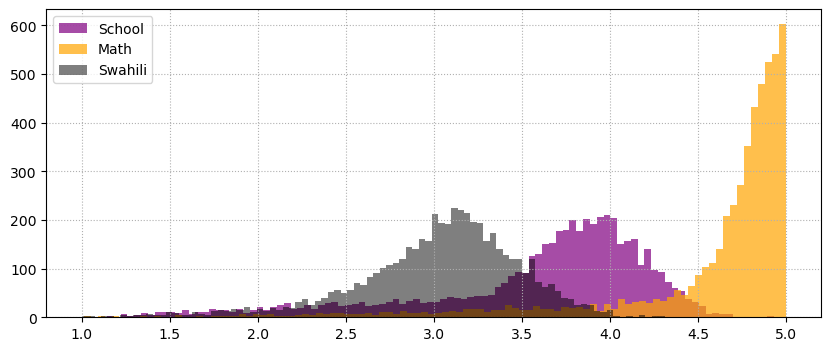

In [215]:
plt.figure(figsize = (10,4))
gpa_df.school_gpa.hist(alpha = 0.7, color = 'purple', bins = 100, label = 'School')
gpa_df.math_gpa.hist(alpha = 0.7, color = 'orange', bins = 100, label = 'Math')
gpa_df.swahili_gpa.hist(alpha = 0.5, color = 'k', bins = 100, label = 'Swahili')
plt.legend()
plt.grid(linestyle = ':')

### Distribution (KDE)

In [216]:
import seaborn as sns

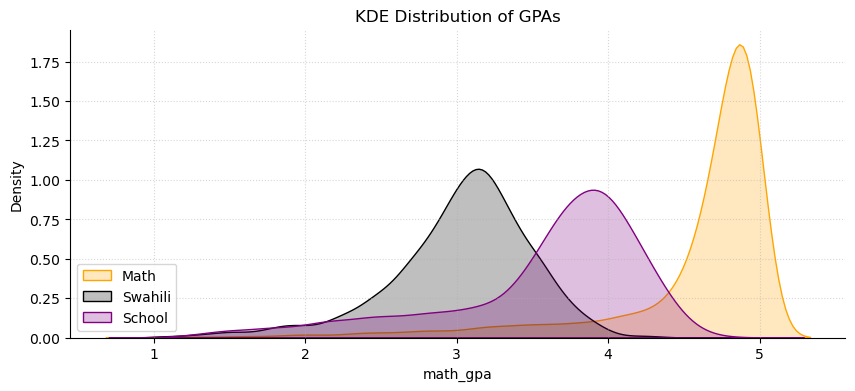

In [217]:
plt.figure(figsize = (10,4))
sns.kdeplot(data=gpa_df, x='math_gpa', fill = True, label = 'Math', color = 'orange')
sns.kdeplot(data=gpa_df, x='swahili_gpa', fill = True, label = 'Swahili', color = 'k')
sns.kdeplot(data=gpa_df, x='school_gpa', fill = True, label = 'School', color = 'purple')
plt.grid( ls = ':', alpha = 0.5, )
plt.title('KDE Distribution of GPAs')
plt.legend(loc = 'lower left')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

### Relationship Between School, Math & Swahili GPA

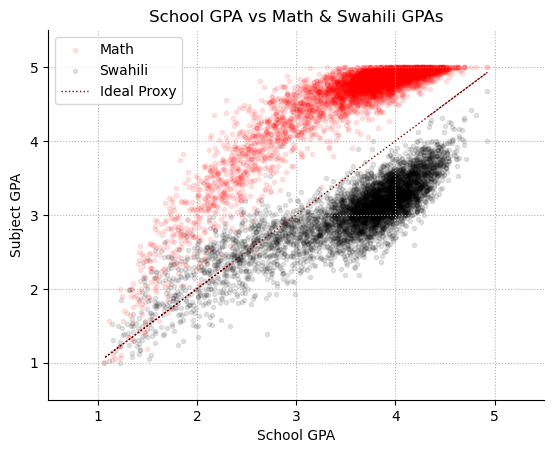

In [218]:
plt.figure()
plt.scatter(gpa_df.school_gpa, gpa_df.math_gpa, alpha = 0.1, marker = '.', color = 'r', label = 'Math')
plt.scatter(gpa_df.school_gpa, gpa_df.swahili_gpa,  alpha = 0.1, marker = '.', color = 'k', label = 'Swahili')
plt.plot(gpa_df.school_gpa, gpa_df.school_gpa, color = 'maroon', linestyle = ':', lw = 1, label = 'Ideal Proxy')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(linestyle = ':')
plt.ylim(0.5,5.5,)
plt.title('School GPA vs Math & Swahili GPAs')
plt.xlim(0.5,5.5)

plt.xlabel('School GPA')
plt.ylabel ('Subject GPA')
plt.legend()

### Inverting GPAs

Within the scope of this analysis I add the inverted value of GPAs to have more intuitive values where lower values reflect lower performance, and the vice versa.

In [219]:
# cols = ['school_gpa', 'math_gpa', 'swahili_gpa']
# cols_inv = ['school_gpa_inv', 'math_gpa_inv', 'swahili_gpa_inv']
# gpa_df[cols_inv] = gpa_df[cols].transform(lambda x: np.log10(1/x*5))
# gpa_df

In [220]:
# plt.figure()
# plt.scatter(gpa_df.school_gpa_inv, gpa_df.math_gpa_inv, alpha = 0.1, marker = '.', color = 'r', label = 'Math')
# plt.scatter(gpa_df.school_gpa_inv, gpa_df.swahili_gpa_inv,  alpha = 0.1, marker = '.', color = 'k', label = 'Swahili')
# plt.plot(gpa_df.school_gpa_inv, gpa_df.school_gpa_inv, color = 'maroon', lw = 1, linestyle = ':', label = 'Ideal')
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.grid(linestyle = ':')
# # plt.ylim(0,5.5,)
# plt.title('Inverted, Log Transformed\nSchool GPA vs Math & Swahili GPAs')
# # plt.xlim(0,5.5)

# plt.xlabel('School GPA')
# plt.ylabel ('Subject GPA')
# plt.legend(fontsize = 8)
# plt.show()

### Does the Number of Students Missing the Exams Relate to the Performance?

In [221]:
cols = ['school_sat', 'math_sat', 'swahili_sat']
cols_gap = ['school_sat_gap', 'math_sat_gap', 'swahili_sat_gap']
gpa_df[cols_gap] = gpa_df[cols].transform(lambda x: (gpa_df.school_regd - x)/gpa_df.school_regd*100)
gpa_df

,Unnamed: 0,name,school_gpa,math_gpa,school_regd,school_sat,math_sat,swahili_gpa,swahili_sat,CNO,school_gpa_inv,math_gpa_inv,swahili_gpa_inv,school_sat_gap,math_sat_gap,swahili_sat_gap
0,0,S0101 AZANIA,2.3338,2.5861,303.0,302,302.0,2.7781,302.0,S0101,0.330906,0.286325,0.255222,0.330033,0.330033,0.330033
1,1,S0104 BWIRU BOYS,2.1258,2.9006,161.0,161,161.0,2.9379,161.0,S0104,0.371448,0.236482,0.230933,0.000000,0.000000,0.000000
2,2,S0106 DUNG'UNYI SEMINARY,2.4457,3.5429,35.0,35,35.0,2.8571,35.0,S0106,0.310567,0.149611,0.243045,0.000000,0.000000,0.000000
3,3,S0107 LUTHERAN JUNIOR SEMINARY,2.7187,4.1918,73.0,73,73.0,2.7123,73.0,S0107,0.264609,0.076569,0.265632,0.000000,0.000000,0.000000
4,4,S0108 IFUNDA TECHNICAL,2.0951,2.3725,153.0,153,153.0,1.9346,153.0,S0108,0.377765,0.323764,0.412379,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5186,5,S6248 NDOLE,4.0299,4.7955,44.0,44,44.0,3.3409,44.0,S6248,0.093676,0.018136,0.175107,0.000000,0.000000,0.000000
5187,6,S6277 SAMA MEMORIAL,4.1995,4.9808,75.0,65,65.0,3.4615,65.0,S6277,0.075772,0.001671,0.159706,13.333333,13.333333,13.333333
5188,7,S6286 NTIMBANJAYO,2.2020,3.5556,18.0,18,18.0,2.2778,18.0,S6286,0.356153,0.148057,0.341454,0.000000,0.000000,0.000000
5189,8,S6300 ASSURANCE SEKONDARY SCHOOL,2.0444,3.0667,15.0,15,15.0,2.1333,15.0,S6300,0.388404,0.212299,0.369918,0.000000,0.000000,0.000000


<AxesSubplot: >

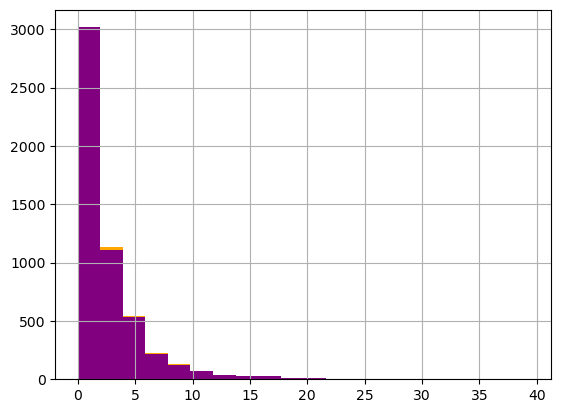

In [222]:
plt.figure()
# plt.scatter(gpa_df.swahili_sat_gap, gpa_df.math_sat_gap, alpha = 0.1, marker = 'x')
gpa_df.swahili_sat_gap.hist(bins = 20, color = 'k')
gpa_df.math_sat_gap.hist(bins = 20, color = 'orange')
gpa_df.school_sat_gap.hist(bins = 20, color = 'purple')

In [204]:
gpa_df.corr(numeric_only = True)

,Unnamed: 0,school_gpa,math_gpa,school_regd,school_sat,math_sat,swahili_gpa,swahili_sat,school_gpa_inv,math_gpa_inv,swahili_gpa_inv,school_sat_gap,math_sat_gap,swahili_sat_gap
Unnamed: 0,1.000000,0.007402,0.014835,0.000894,0.001508,0.001486,0.008781,0.001531,-0.009582,-0.015980,-0.011406,-0.013766,-0.013025,-0.014198
school_gpa,0.007402,1.000000,0.895645,0.209150,0.201676,0.201743,0.854237,0.201790,-0.987778,-0.849480,-0.856077,0.269703,0.268662,0.267489
math_gpa,0.014835,0.895645,1.000000,0.128270,0.120896,0.121049,0.730814,0.121038,-0.934571,-0.984812,-0.770728,0.229864,0.225590,0.226461
school_regd,0.000894,0.209150,0.128270,1.000000,0.999279,0.999269,0.181686,0.999277,-0.196091,-0.117585,-0.172769,0.480895,0.497182,0.487765
school_sat,0.001508,0.201676,0.120896,0.999279,1.000000,0.999987,0.175321,0.999996,-0.188552,-0.110601,-0.166324,0.447262,0.464187,0.454370
math_sat,0.001486,0.201743,0.121049,0.999269,0.999987,1.000000,0.175271,0.999985,-0.188656,-0.110744,-0.166320,0.447344,0.463659,0.454386
swahili_gpa,0.008781,0.854237,0.730814,0.181686,0.175321,0.175271,1.000000,0.175439,-0.842400,-0.702312,-0.986447,0.231349,0.232953,0.229010
swahili_sat,0.001531,0.201790,0.121038,0.999277,0.999996,0.999985,0.175439,1.000000,-0.188684,-0.110740,-0.166457,0.447304,0.464163,0.454215
school_gpa_inv,-0.009582,-0.987778,-0.934571,-0.196091,-0.188552,-0.188656,-0.842400,-0.188684,1.000000,0.905702,0.863212,-0.265145,-0.263021,-0.262415
math_gpa_inv,-0.015980,-0.849480,-0.984812,-0.117585,-0.110601,-0.110744,-0.702312,-0.110740,0.905702,1.000000,0.753711,-0.215875,-0.211817,-0.212523


### How General is the Pattern Across Regions?

In [226]:
sch_info = frame[['centre_ref', 'centre_name', 'region']].drop_duplicates(subset=['centre_ref']).copy()
sch_info

,centre_ref,centre_name,region
0,S0101,AZANIA,DAR ES SALAAM
303,S0104,BWIRU BOYS,MWANZA
464,S0106,DUNG'UNYI SEMINARY,SINGIDA
499,S0107,LUTHERAN JUNIOR SEMINARY,MOROGORO
572,S0108,IFUNDA TECHNICAL,IRINGA
...,...,...,...
534443,S6248,NDOLE,MOROGORO
534487,S6277,SAMA MEMORIAL,MOROGORO
534562,S6286,NTIMBANJAYO,RUVUMA
534580,S6300,ASSURANCE SEKONDARY SCHOOL,DAR ES SALAAM


In [259]:
all_df = pd.merge(sch_info, gpa_df, left_on = 'centre_ref', right_on = 'CNO', how = 'inner').drop(columns = ['Unnamed: 0', 'name', 'CNO'])
all_df = all_df.sort_values(by = 'math_gpa')

In [260]:
regs = all_df.region.unique()
print(len(regs))

31


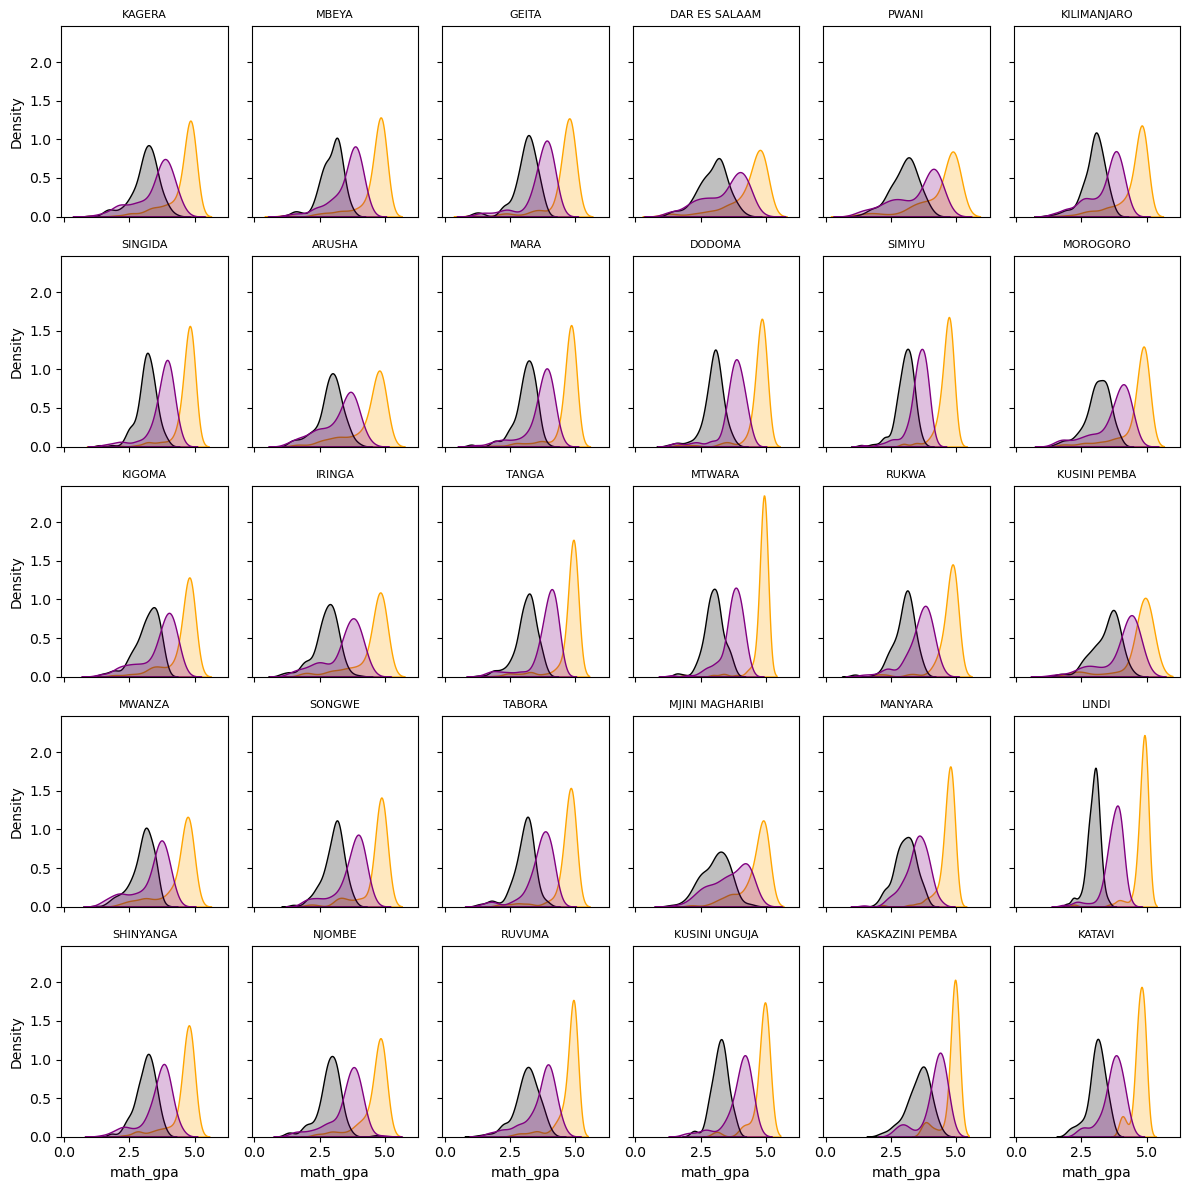

In [264]:
fig, ax = plt.subplots(5,6, figsize = (12,12), sharex = True, sharey = True)

i = j = 0
counter = 0
for reg in regs[:30]:
    i = counter % 6
    j = counter//6
    axn = ax[j,i]
    reg_df = all_df[all_df.region == reg]
#     plt.figure(figsize = (10,4))
    sns.kdeplot(data=reg_df, x='math_gpa', fill = True, label = 'Math', color = 'orange', ax = axn)
    sns.kdeplot(data=reg_df, x='swahili_gpa', fill = True, label = 'Swahili', color = 'k', ax = axn)
    sns.kdeplot(data=reg_df, x='school_gpa', fill = True, label = 'School', color = 'purple', ax = axn)
    axn.set_title(reg, fontsize = 8)
#     plt.grid( ls = ':', alpha = 0.5, )
#     plt.title('KDE Distribution of GPAs')
#     plt.legend(loc = 'lower left')
#     plt.gca().spines['top'].set_visible(False)
#     plt.gca().spines['right'].set_visible(False)
    counter += 1

plt.tight_layout()

#### The outlier

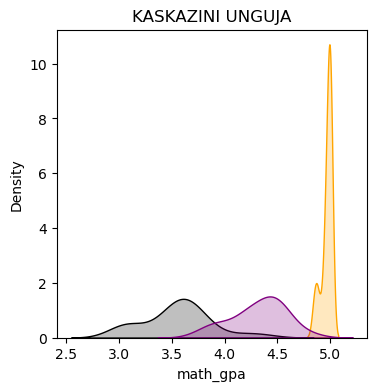

In [268]:
reg_df = all_df[all_df.region == regs[-1]]

plt.figure(figsize = (4,4))
sns.kdeplot(data=reg_df, x='math_gpa', fill = True, label = 'Math', color = 'orange')
sns.kdeplot(data=reg_df, x='swahili_gpa', fill = True, label = 'Swahili', color = 'k')
sns.kdeplot(data=reg_df, x='school_gpa', fill = True, label = 'School', color = 'purple')

plt.title(regs[-1])

plt.show()